In [ ]:
#import functions
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torchsummary import summary
import math
import pandas as pd
import torch.nn.functional as F
import random
import torch.optim as optim
from scipy.io import loadmat
import numpy as np
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
import scipy.io

In [ ]:
import torch

try:
    version = torch.__version__
    print(f"PyTorch version: {version}")
except AttributeError:
    print("PyTorch version attribute is not available.")

PyTorch version: 2.5.0+cu121


In [ ]:
#!pip list

# Data Analysis

## Import Data

This code was written in colab and the syntax to load in the data is given below

In [ ]:
tlds = torch.tensor((pd.read_csv('tlds.csv')).values)
tlgs = torch.tensor((pd.read_csv('tlgs.csv')).values)
taus = torch.tensor((pd.read_csv('taus.csv')).values)
kps = torch.tensor((pd.read_csv('kps.csv')).values)

p = torch.tensor((pd.read_csv('pilotoutput.csv')).values)
pitch_error = torch.tensor((pd.read_csv('pitcherror.csv')).values)
pitch_cmd = torch.tensor((pd.read_csv('pitchcmd.csv')).values)
pitch_out = torch.tensor((pd.read_csv('pitchoutput.csv')).values)

xp = torch.tensor((pd.read_csv('xpilot.csv')).values)

Ts = 0.1
Tfinal = 100
length = Tfinal/Ts
time = torch.arange(0, Tfinal + Ts, Ts)[:-1].view(-1,1)

In [ ]:
# Check the shapes
tlds.shape, tlgs.shape, taus.shape, kps.shape, p.shape, pitch_error.shape, pitch_cmd.shape, pitch_out.shape, xp.shape, time.shape

(torch.Size([1000, 750]),
 torch.Size([1000, 750]),
 torch.Size([1000, 750]),
 torch.Size([1000, 750]),
 torch.Size([1000, 750]),
 torch.Size([1000, 750]),
 torch.Size([1000, 750]),
 torch.Size([1000, 750]),
 torch.Size([1000, 750]),
 torch.Size([1000, 1]))

## Check for outliers

due to certain parameter configurations cause the pilot response to diverge
we will filter out sets of data that correspond to data where the pilot response blew up

In [ ]:
# Check if each column of tensor1 is larger than the corresponding column of tensor2
is_column_larger = tlgs > tlds

# Check if all columns of tensor1 are larger than corresponding columns of tensor2
are_all_columns_larger = torch.all(is_column_larger, dim=0)

print("Are all columns of tlgs larger than corresponding columns of tlds:", torch.all(are_all_columns_larger).item())

Are all columns of tlgs larger than corresponding columns of tlds: True


In [ ]:

# Threshold value
threshold = 1.7

# Find the maximum value of each column
max_values, _ = torch.max(pitch_out, dim=0)

# Obtain the column numbers where the maximum value exceeds the threshold
columns_above_threshold = torch.nonzero(max_values > threshold).squeeze()

print("Column numbers where max value exceeds the threshold:", columns_above_threshold.tolist())

# Create a mask to select columns to keep
mask = torch.ones(pitch_out.size(1), dtype=torch.bool)
mask[columns_above_threshold] = False

# Delete columns based on the mask
pitch_out_filtered = pitch_out[:, mask]


tlds_filtered = tlds[:,mask]
tlgs_filtered = tlgs[:,mask]
taus_filtered = taus[:,mask]
kps_filtered=kps[:,mask]
p_filtered = p[:,mask]
pitch_cmd_filtered = pitch_cmd[:,mask]
pitch_error_filtered = pitch_error[:,mask]
xp_filtered = xp[:,mask]

pitch_out_filtered.shape, tlds_filtered.shape, tlgs_filtered.shape, kps_filtered.shape,p_filtered.shape, pitch_cmd_filtered.shape,pitch_error_filtered.shape,xp_filtered.shape


Column numbers where max value exceeds the threshold: [25, 57, 70, 108, 157, 210, 224, 291, 330, 447, 511, 518, 582, 678, 733]


(torch.Size([1000, 735]),
 torch.Size([1000, 735]),
 torch.Size([1000, 735]),
 torch.Size([1000, 735]),
 torch.Size([1000, 735]),
 torch.Size([1000, 735]),
 torch.Size([1000, 735]),
 torch.Size([1000, 735]))

## Turn to tensors

In [ ]:
tlds_tensor = torch.tensor(tlds_filtered, dtype=torch.float32)
tlgs_tensor = torch.tensor(tlgs_filtered, dtype=torch.float32)
taus_tensor = torch.tensor(taus_filtered, dtype=torch.float32)
kps_tensor = torch.tensor(kps_filtered, dtype=torch.float32)
p_tensor = torch.tensor(p_filtered, dtype=torch.float32)
pitch_error_tensor = torch.tensor(pitch_error_filtered, dtype=torch.float32)
pitch_cmd_tensor = torch.tensor(pitch_cmd_filtered, dtype=torch.float32)
pitch_out_tensor = torch.tensor(pitch_out_filtered, dtype=torch.float32)
xp_tensor = torch.tensor(xp_filtered, dtype=torch.float32)
time_tensor = torch.tensor(time, dtype=torch.float32)

<ipython-input-10-08f96ad93015>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tlds_tensor = torch.tensor(tlds_filtered, dtype=torch.float32)
<ipython-input-10-08f96ad93015>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tlgs_tensor = torch.tensor(tlgs_filtered, dtype=torch.float32)
<ipython-input-10-08f96ad93015>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  taus_tensor = torch.tensor(taus_filtered, dtype=torch.float32)
<ipython-input-10-08f96ad93015>:4: UserWarning: To copy construct from a tensor, it is recommended to use source

## Normalize data

In [ ]:
pitch_cmd_tensor_norm = (pitch_cmd_tensor - pitch_cmd_tensor.min(dim=0).values) / (pitch_cmd_tensor.max(dim=0).values - pitch_cmd_tensor.min(dim=0).values)
pitch_out_tensor_norm = (pitch_out_tensor - pitch_out_tensor.min(dim=0).values) / (pitch_out_tensor.max(dim=0).values - pitch_out_tensor.min(dim=0).values)
pitch_error_tensor_norm = (pitch_error_tensor - pitch_error_tensor.min(dim=0).values) / (pitch_error_tensor.max(dim=0).values - pitch_error_tensor.min(dim=0).values)

In [ ]:
pilot_output_tensor_norm = (p_tensor - p_tensor.min(dim=0).values) / (p_tensor.max(dim=0).values - p_tensor.min(dim=0).values)

In [ ]:
has_nan = torch.isnan(pitch_out_tensor_norm).any().item()
has_inf = torch.isinf(pitch_out_tensor_norm).any().item()
if has_nan:
    print("Tensor contains NaN values.")
if has_inf:
    print("Tensor contains Infinity values.")

num_nans = torch.isnan(pitch_out_tensor_norm).sum().item()
num_infs = torch.isinf(pitch_out_tensor_norm).sum().item()

print("Number of NaNs:", num_nans)
print("Number of Infs:", num_infs)

Number of NaNs: 0
Number of Infs: 0


In [ ]:
time_norm = (time - time.min(dim=0).values) / (time.max(dim=0).values - time.min(dim=0).values)

## Create X

In [ ]:
tensor_list = []
for i in range(tlds_tensor.shape[1]):
  tensor_2d = (torch.cat((pitch_cmd_tensor_norm[:,i].view(-1,1), pitch_out_tensor_norm[:,i].view(-1,1),pitch_error_tensor_norm[:,i].view(-1,1),time_norm[:]),dim=1))
  tensor_list.append(tensor_2d)
X = torch.stack(tensor_list)
X.shape #this is in the shape of (# of runs, data points, # of features)

torch.Size([735, 1000, 4])

In [ ]:
tensor_list = []
for i in range(tlds_tensor.shape[1]):
  tensor_2d = (torch.cat((pitch_cmd_tensor_norm[:,i].view(-1,1), pitch_out_tensor_norm[:,i].view(-1,1),pitch_error_tensor_norm[:,i].view(-1,1),pilot_output_tensor_norm[:,i].view(-1,1), time_norm[:]),dim=1))
  tensor_list.append(tensor_2d)
X = torch.stack(tensor_list)
X.shape #this is in the shape of (# of runs, data points, # of features)

torch.Size([735, 1000, 5])

## Create y

In [ ]:
tlds_tensor_2 =  tlds_tensor.T
tlgs_tensor_2 = tlgs_tensor.T
taus_tensor_2 = taus_tensor.T
kps_tensor_2 = kps_tensor.T
tlds_tensor_2.shape

tensor_list = []
for j in range(tlds_tensor.shape[1]):
  row_tensor = torch.concat((xp_tensor.T[j,:].view(1,-1),tlds_tensor_2[j,:].view(1,-1),tlgs_tensor_2[j,:].view(1,-1),taus_tensor_2[j,:].view(1,-1), kps_tensor_2[j,:].view(1,-1)),dim=1)
  tensor_list.append(row_tensor)

y = torch.stack(tensor_list)
y=torch.squeeze(y)
y.shape

torch.Size([735, 5000])

## Train/Test split

In [ ]:
p_tensor.T.shape, pitch_error_tensor.T.shape

(torch.Size([735, 1000]), torch.Size([735, 1000]))

In [ ]:
import sklearn
from sklearn.model_selection import train_test_split

Xtrain, Xtest, pitcherrortrain, pitcherrortest, ptrain, ptest, ytrain, ytest = train_test_split(
    X, pitch_error_tensor.T, p_tensor.T, y,
    test_size=0.2,        # Proportion of the dataset to include in the test split
    random_state=123       # Seed for the random number generator
)

Xtrain.shape, Xtest.shape, pitcherrortrain.shape, pitcherrortest.shape, ptrain.shape, ptest.shape, ytrain.shape, ytest.shape

(torch.Size([588, 1000, 5]),
 torch.Size([147, 1000, 5]),
 torch.Size([588, 1000]),
 torch.Size([147, 1000]),
 torch.Size([588, 1000]),
 torch.Size([147, 1000]),
 torch.Size([588, 5000]),
 torch.Size([147, 5000]))

In [ ]:
Xtrain_flattened = Xtrain.reshape(Xtrain.shape[0], -1)
Xtrain_flattened.shape

torch.Size([588, 5000])

In [ ]:
Xtest_flattened = Xtest.reshape(Xtest.shape[0], -1)
Xtest_flattened.shape

torch.Size([147, 5000])

### Train/Test visualization

In [ ]:
ytrain.shape, ytest.shape

(torch.Size([588, 5000]), torch.Size([147, 5000]))

In [ ]:
tldstrain = ytrain[:,1000:2000]
tlgsstrain = ytrain[:,2000:3000]
tausstrain = ytrain[:,3000:4000]
kpstrain = ytrain[:,4000:5000]

tldstrain_avg = tldstrain.mean(axis=1, keepdims=True)
tlgsstrain_avg = tlgsstrain.mean(axis=1, keepdims=True)
tausstrain_avg = tausstrain.mean(axis=1, keepdims=True)
kpstrain_avg = kpstrain.mean(axis=1, keepdims=True)

tldstrain_avg.shape, tlgsstrain_avg.shape, tausstrain_avg.shape, kpstrain_avg.shape

(torch.Size([588, 1]),
 torch.Size([588, 1]),
 torch.Size([588, 1]),
 torch.Size([588, 1]))

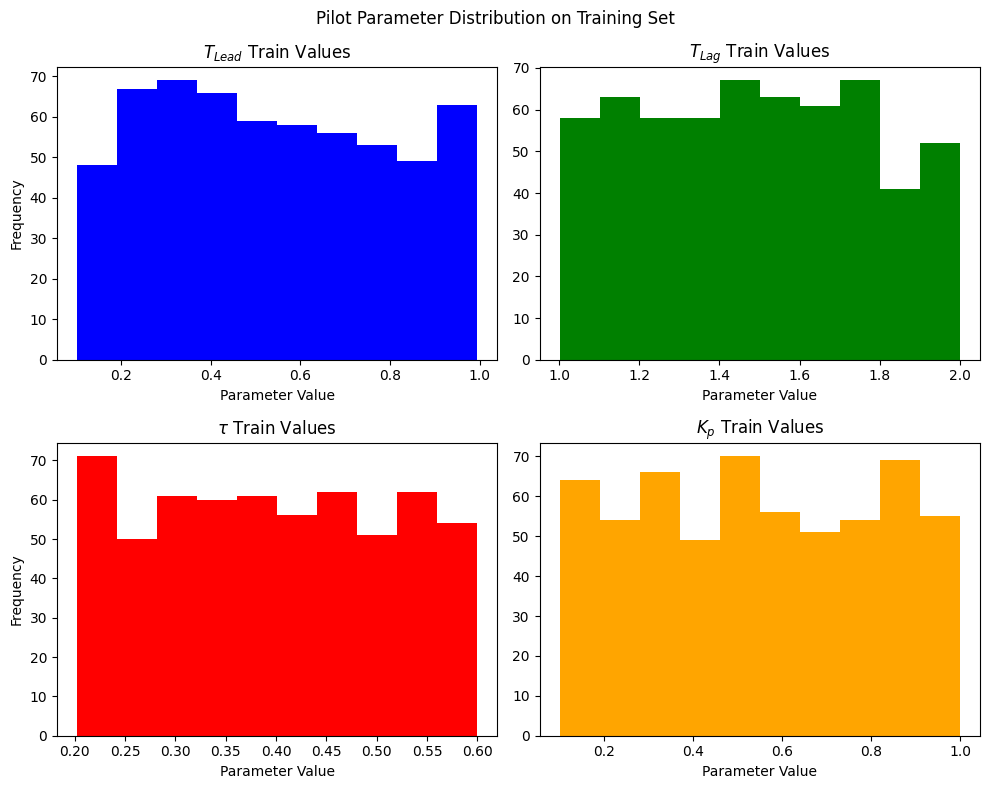

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

axs[0,0].hist(tldstrain_avg.squeeze(), color='blue')
axs[0,0].set_title(r'$T_{Lead}$ Train Values')
axs[0,0].set_xlabel('Parameter Value')
axs[0,0].set_ylabel('Frequency')

axs[0,1].hist(tlgsstrain_avg.squeeze(), color='green')
axs[0,1].set_title(r'$T_{Lag}$ Train Values')
axs[0,1].set_xlabel('Parameter Value')

axs[1,0].hist(tausstrain_avg.squeeze(), color='red')
axs[1,0].set_title(r'$\tau$ Train Values')
axs[1,0].set_xlabel('Parameter Value')
axs[1,0].set_ylabel('Frequency')

axs[1,1].hist(kpstrain_avg.squeeze(), color='orange')
axs[1,1].set_title(r'$K_{p}$ Train Values')
axs[1,1].set_xlabel('Parameter Value')
#axs[1,1].set_ylabel('Frequency')

fig.suptitle('Pilot Parameter Distribution on Training Set');


plt.tight_layout()
plt.show()

In [ ]:
tldstest = ytest[:,1000:2000]
tlgsstest = ytest[:,2000:3000]
tausstest = ytest[:,3000:4000]
kpstest = ytest[:,4000:5000]

tldstest_avg = tldstest.mean(axis=1, keepdims=True)
tlgsstest_avg = tlgsstest.mean(axis=1, keepdims=True)
tausstest_avg = tausstest.mean(axis=1, keepdims=True)
kpstest_avg = kpstest.mean(axis=1, keepdims=True)

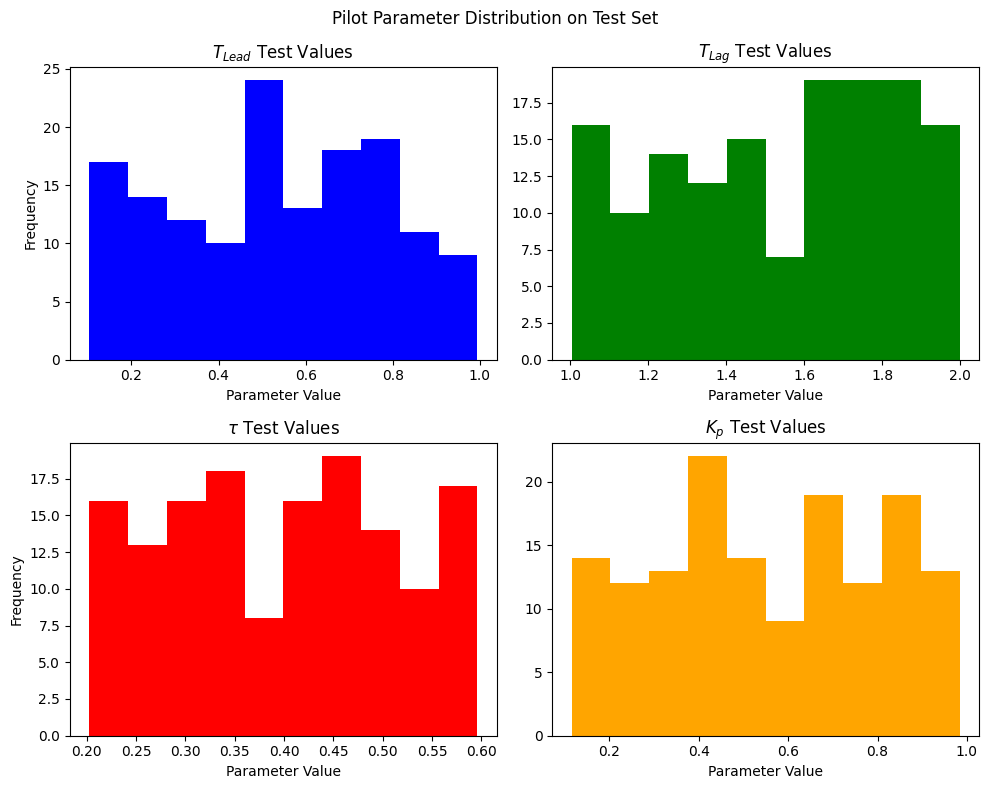

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

axs[0,0].hist(tldstest_avg.squeeze(), color='blue')
axs[0,0].set_title(r'$T_{Lead}$ Test Values')
axs[0,0].set_xlabel('Parameter Value')
axs[0,0].set_ylabel('Frequency')

axs[0,1].hist(tlgsstest_avg.squeeze(), color='green')
axs[0,1].set_title(r'$T_{Lag}$ Test Values')
axs[0,1].set_xlabel('Parameter Value')

axs[1,0].hist(tausstest_avg.squeeze(), color='red')
axs[1,0].set_title(r'$\tau$ Test Values')
axs[1,0].set_xlabel('Parameter Value')
axs[1,0].set_ylabel('Frequency')

axs[1,1].hist(kpstest_avg.squeeze(), color='orange')
axs[1,1].set_title(r'$K_{p}$ Test Values')
axs[1,1].set_xlabel('Parameter Value')
#axs[1,1].set_ylabel('Frequency')

fig.suptitle('Pilot Parameter Distribution on Test Set');

plt.tight_layout()
plt.show()

# Create NN

In [ ]:
# Create dense model
class DenseModel(nn.Module):
    def __init__(self):
        super(DenseModel, self).__init__()
        # Define the layers
        self.layer1 = nn.Linear(Xtrain_flattened.shape[1], 256)
        #self.layer2 = nn.Linear(256, 256)
        #self.layer3 = nn.Linear(256, 256)
        self.layer2 = nn.Linear(256, 512)
        self.layer3 = nn.Linear(512, ytrain.shape[1])

        # Apply Glorot initialization to the linear layers
        #nn.init.xavier_uniform_(self.layer1.weight)
        #nn.init.xavier_uniform_(self.layer2.weight)
        #nn.init.xavier_uniform_(self.layer3.weight)
        #nn.init.xavier_uniform_(self.layer4.weight)
        #nn.init.xavier_uniform_(self.layer5.weight)

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        #x = torch.relu(self.layer3(x))
        #x = torch.relu(self.layer4(x))
        x = self.layer3(x)
        x[3000:4000] = 0.1 + 0.9 * torch.sigmoid(x[3000:4000])
        return x

# Create an instance of the model
model_1 = DenseModel()

# Create Custom Dataset

In [ ]:
from torch.utils.data import Dataset, DataLoader
torch.manual_seed(123)
# Create a custom dataset
class CustomDataset(Dataset):
    def __init__(self, X_train, y_train, additional_data1, additional_data2):
        self.X_train = X_train
        self.y_train = y_train
        self.additional_data1 = additional_data1
        self.additional_data2 = additional_data2

    def __len__(self):
        return len(self.X_train)

    def __getitem__(self, idx):
        x = self.X_train[idx]
        y = self.y_train[idx]
        additional1 = self.additional_data1[idx]
        additional2 = self.additional_data2[idx]
        return x, y, additional1, additional2

# Define batch size
batch_size = 32

# Create the custom dataset
custom_dataset = CustomDataset(X_train=Xtrain_flattened, y_train=ytrain, additional_data1=ptrain, additional_data2=pitcherrortrain)

# Create DataLoader with shuffle=False
train_loader = DataLoader(custom_dataset, batch_size=batch_size, shuffle=False)


# Setup training parameters

In [ ]:
torch.manual_seed(123)

# define the optimiser
optimiser = torch.optim.Adam(model_1.parameters(), lr=1e-3)

# define the number of epochs
epochs = 100

# collect the loss history
total_loss_history=[]
pilot_output_loss_history=[]
xpilot_calcualted_loss_history=[]
params_loss_history=[]


# define the loss criteria
criterion= nn.MSELoss()

# Training Loop

same helper function to create delayed data to simulate e(t-tau)

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def transport_delay(data, tau, time_step, initial_value):
    """
    Applies a transport delay to a 1D tensor of time series data.

    Parameters:
    - data: 1D PyTorch tensor containing the time series data.
    - tau: The delay in seconds.
    - time_step: The time step between consecutive samples in seconds.
    - initial_value: The value to fill in the delayed portion of the tensor.

    Returns:
    - delayed_data: The tensor with the applied delay.
    """
    if not isinstance(data, torch.Tensor):
        raise ValueError("data should be a PyTorch tensor")

    if data.dim() != 1:
        raise ValueError("data should be a 1D tensor")

    # Calculate the number of samples to delay
    #delay_steps = int(round(tau / time_step))
    delay_steps = (int((tau / time_step)))

    # Ensure delay_steps is non-negative
    delay_steps = max(delay_steps, 0)

    # Create a tensor with the same shape as data, filled with initial_value
    delayed_data = torch.full_like(data, initial_value)

    # Apply the delay by shifting the data tensor
    if delay_steps < len(data):
        delayed_data[delay_steps:] = data[:-delay_steps]
    else:
        # If delay_steps is larger than the data length, return all initial values
        delayed_data = torch.full_like(data, initial_value)

    return delayed_data

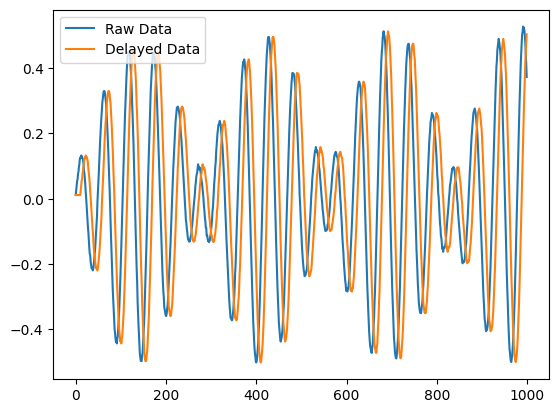

In [ ]:
plt.plot(pitcherrortrain[17,:], label="Raw Data")
plt.plot(transport_delay(pitcherrortrain[17,:], 1, 0.1, pitcherrortrain[17,:][0]), label="Delayed Data")
plt.legend()
plt.show()

In [ ]:
len(train_loader)

19

In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
#scheduler = ReduceLROnPlateau(optimiser, 'min', patience=len(train_loader)*10, factor=0.1, verbose=True)


torch.manual_seed(123)

switch_epoch = 10
for epoch in range(epochs):

    model_1.train()

    tensor_list = []
    xpilot_list=[]

    for batch_X, batch_y, batch_additional1, batch_additional2 in train_loader:

      # Zero the gradients
      optimiser.zero_grad()

      # Forward pass
      xp_est, params_est = model_1(batch_X)[:,:1000], model_1(batch_X)[:,-4000:]

      # Compute X_pilot loss
      xpilot_loss = criterion(xp_est[:,:300], batch_y[:,:300])

      # Compute parameters loss
      #lambda_reg = 0.1
      #tld_loss = criterion(params_est[:,0:1000], batch_y[:,1000:2000]) #+ lambda_reg*torch.sum((params_est[:,0:1000]- batch_y[:,1000:2000])**2)
      #tlg_loss = criterion(params_est[:,1000:2000],batch_y[:,2000:3000]) #+ lambda_reg*torch.sum((params_est[:,1000:2000]- batch_y[:,2000:3000])**2)
      #tau_loss = criterion(params_est[:,2000:3000],batch_y[:,3000:4000])
      #kp_loss = criterion(params_est[:,3000:],batch_y[:,4000:])
      #params_loss = tld_loss + tlg_loss + tau_loss + kp_loss
      params_loss = criterion(params_est, batch_y[:,-4000:])
      params_loss_history.append(params_loss.item())

      if epoch >= switch_epoch:
        # Compute physics losses
        for x in range(batch_X.shape[0]):
          u = xp_est[x,:]
          tld_t,tlg_t,tau_t,kp_t = params_est[x,:1000],params_est[x,1000:2000],params_est[x,2000:3000], params_est[x,3000:4000]
          pitcherror_t_tau = transport_delay(batch_additional2[x,:], tau_t.mean(), 0.1, batch_additional2[x,:][0])

          # Calculate estimated pilot output
          pilot_output_estimated = ((-kp_t/(tlg_t*tlg_t))*(tlg_t-tld_t)*u - (kp_t*tld_t/tlg_t)*pitcherror_t_tau).view(1,-1)
          tensor_list.append(pilot_output_estimated)

          # Calculate estimated x pilot
          xpilot_calcualted = ((pitcherror_t_tau)/tlg_t) - ((pitcherror_t_tau/tlg_t)*(torch.exp(-time.squeeze()/tlg_t))).reshape(1,-1)
          xpilot_list.append(xpilot_calcualted)


        # Compute pilot output loss
        pilot_output_concat = torch.cat(tensor_list, dim=0)
        pilot_output_loss = criterion(pilot_output_concat,batch_additional1)
        pilot_output_loss_history.append(pilot_output_loss.item())
        tensor_list.clear()

        # Compute calculated x pilot loss
        xpilot_calcualted_concat = torch.cat(xpilot_list,dim=0)
        xpilot_calculated_loss = criterion(xpilot_calcualted_concat,batch_y[:,:1000])
        xpilot_calcualted_loss_history.append(xpilot_calculated_loss)
        xpilot_list.clear()


      if epoch < switch_epoch:
        loss = xpilot_loss + params_loss
      else:
        loss = xpilot_loss + params_loss + pilot_output_loss + xpilot_calculated_loss
      total_loss_history.append(loss.item())


      # Backward pass
      loss.backward()


      # Update step
      optimiser.step()
    # Print results
    print(f"Epoch {epoch+1}/{epochs}, Total Loss: {loss.item():.4f}")

    # Step the scheduler
    #scheduler.step(loss)

Epoch 1/100, Total Loss: 0.0603
Epoch 2/100, Total Loss: 0.0593
Epoch 3/100, Total Loss: 0.0415
Epoch 4/100, Total Loss: 0.0427
Epoch 5/100, Total Loss: 0.0402
Epoch 6/100, Total Loss: 0.0377
Epoch 7/100, Total Loss: 0.0337
Epoch 8/100, Total Loss: 0.0333
Epoch 9/100, Total Loss: 0.0325
Epoch 10/100, Total Loss: 0.0339
Epoch 11/100, Total Loss: 0.0387
Epoch 12/100, Total Loss: 0.0369
Epoch 13/100, Total Loss: 0.0358
Epoch 14/100, Total Loss: 0.0365
Epoch 15/100, Total Loss: 0.0362
Epoch 16/100, Total Loss: 0.0351
Epoch 17/100, Total Loss: 0.0342
Epoch 18/100, Total Loss: 0.0341
Epoch 19/100, Total Loss: 0.0339
Epoch 20/100, Total Loss: 0.0338
Epoch 21/100, Total Loss: 0.0337
Epoch 22/100, Total Loss: 0.0339
Epoch 23/100, Total Loss: 0.0336
Epoch 24/100, Total Loss: 0.0326
Epoch 25/100, Total Loss: 0.0314
Epoch 26/100, Total Loss: 0.0378
Epoch 27/100, Total Loss: 0.0323
Epoch 28/100, Total Loss: 0.0342
Epoch 29/100, Total Loss: 0.0335
Epoch 30/100, Total Loss: 0.0325
Epoch 31/100, Total

# Testing and Results

## Loss history

In [ ]:
epochs_batch = torch.tensor(total_loss_history[:]).reshape(-1,len(train_loader))
epochs_batch1 = torch.mean(epochs_batch,dim=1)
epochs_batch1.shape

torch.Size([100])

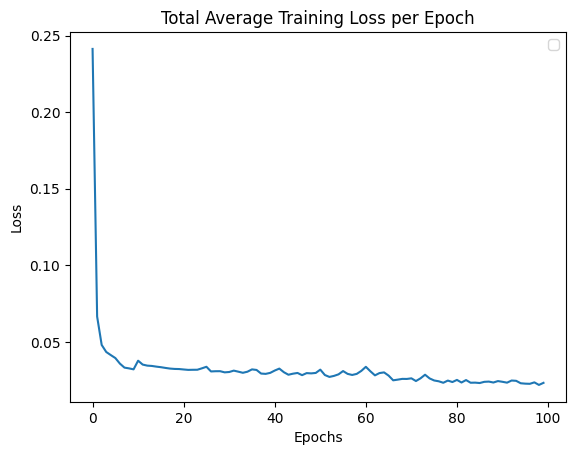

In [ ]:
plt.plot(epochs_batch1[:])


plt.xlabel('Epochs')
plt.legend()
plt.title('Total Average Training Loss per Epoch');
plt.ylabel('Loss');

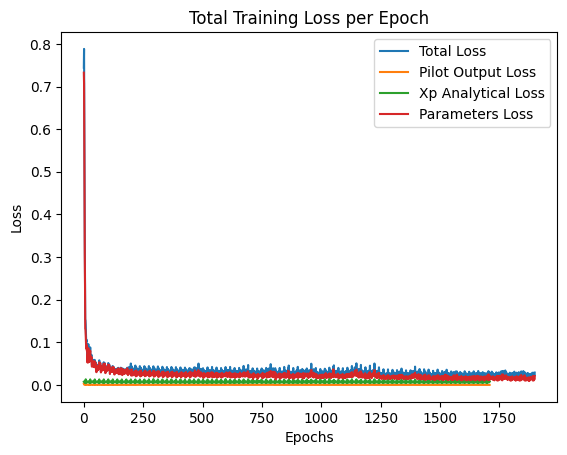

In [ ]:
plt.plot(torch.tensor(total_loss_history[:]), label = 'Total Loss')
plt.plot(torch.tensor(pilot_output_loss_history[:]), label = 'Pilot Output Loss')
plt.plot(torch.tensor(xpilot_calcualted_loss_history[:]), label= 'Xp Analytical Loss')
plt.plot(torch.tensor(params_loss_history[:]), label = 'Parameters Loss')
plt.xlabel('Epochs')
plt.legend()
plt.title('Total Training Loss per Epoch');
plt.ylabel('Loss');
#

## Parameter errors

In [ ]:
model_1.eval()

with torch.no_grad():

  # grab estimated params
  dense_model_preds = model_1(Xtest_flattened)
  estimated_params = dense_model_preds[:,-4000:]
  tld_est,tlg_est,tau_est,kp_est = estimated_params[:,:1000],estimated_params[:,1000:2000],estimated_params[:,2000:3000],estimated_params[:,3000:4000]


  # grab true params
  true_params = ytest[:,-4000:]
  tld_true,tlg_true,tau_true,kp_true = true_params[:,:1000],true_params[:,1000:2000],true_params[:,2000:3000],true_params[:,3000:4000]

  from sklearn.metrics import mean_absolute_error, mean_squared_error
  tld_mse = mean_squared_error(tld_true,tld_est)
  tlg_mse = mean_squared_error(tlg_true,tlg_est)
  tau_mse = mean_squared_error(tau_true,tau_est)
  kp_mse = mean_squared_error(kp_true,kp_est)

In [ ]:
tld_est.shape, tlg_est.shape, tau_est.shape, kp_est.shape

(torch.Size([147, 1000]),
 torch.Size([147, 1000]),
 torch.Size([147, 1000]),
 torch.Size([147, 1000]))

In [ ]:
tld_est.mean(dim = 1).unsqueeze(1).shape

torch.Size([147, 1])

In [ ]:
params_preds = torch.cat((tld_est.mean(dim = 1).unsqueeze(1), tlg_est.mean(dim = 1).unsqueeze(1), tau_est.mean(dim = 1).unsqueeze(1), kp_est.mean(dim = 1).unsqueeze(1)), dim=1)
params_preds.shape

torch.Size([147, 4])

In [ ]:
# Save the NumPy array to a CSV file
# np.savetxt('params_preds.csv', params_preds.numpy(), delimiter=',')

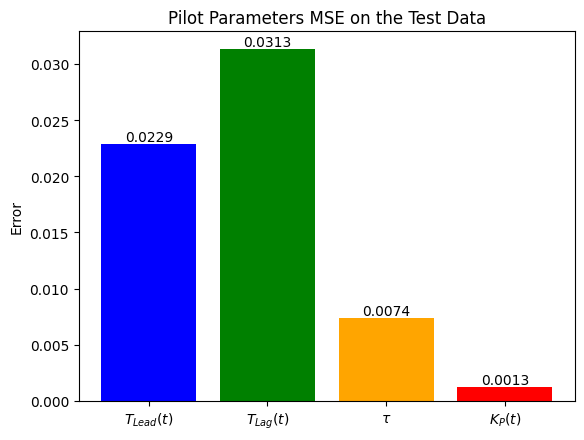

In [ ]:
values = [tld_mse, tlg_mse, tau_mse, kp_mse]

# Corresponding labels for each value
labels = ["$T_{Lead}(t)$", "$T_{Lag}(t)$", r"$\tau$", "$K_{P}(t)$"]

# Specify colors for each bar
colors = ['blue', 'green', 'orange','red']

# Create a bar plot
plt.bar(labels, values,color=colors)

# Add labels to each bar
for label, value in zip(labels, values):
    plt.text(label, value , '{:.4f}'.format(value), ha='center', va='bottom')

# Add labels and title
plt.title('Pilot Parameters MSE on the Test Data')
plt.ylabel('Error')
#plt.title('Bar Plot of Four Values')

# Display the plot
plt.show()

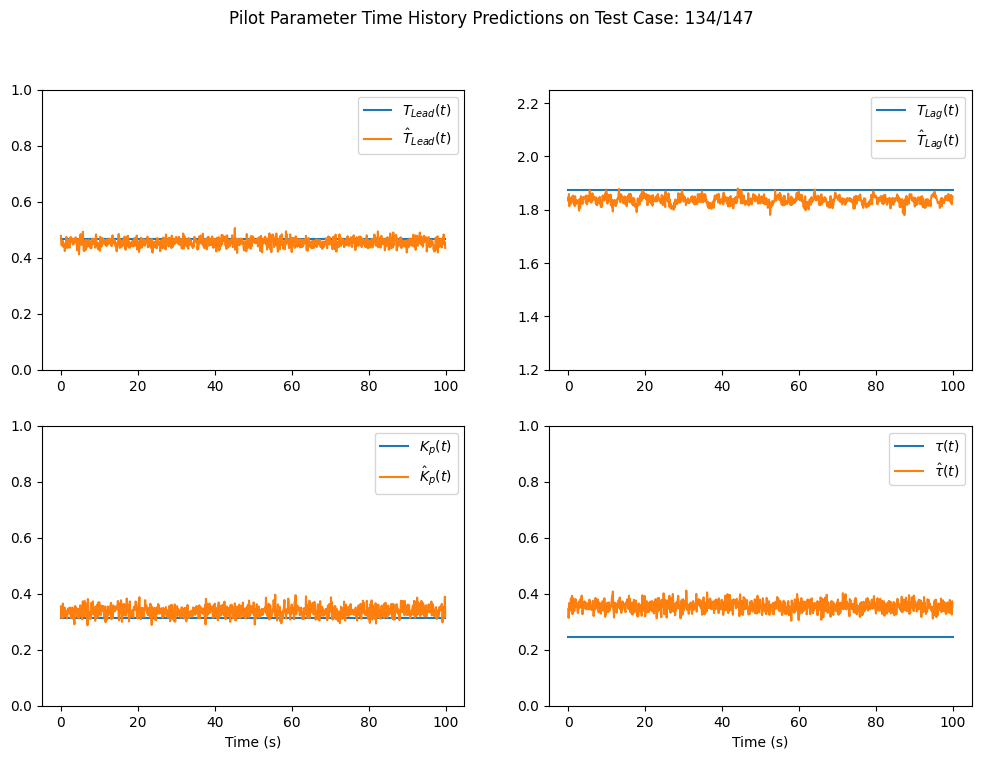

In [ ]:
# lets see a sample parameters time history

test_run = random.randint(0, len(Xtest_flattened)-1) #48 #44
fig, axs = plt.subplots(2, 2, figsize=(12,8))

axs[0,0].plot(time, tld_true[test_run,:], label= "$T_{Lead}(t)$")
axs[0,0].plot(time, tld_est[test_run,:], label= "$\hat{T}_{Lead}(t)$")
#axs[0,0].set_title(f'Parameter Time History Predictions on Test Case: {test_run}/{len(Xtest_flattened)}')
axs[0,0].set_ylim(0, 1)

axs[0,1].plot(time, tlg_true[test_run,:], label= "$T_{Lag}(t)$")
axs[0,1].plot(time, (tlg_est[test_run,:]), label= "$\hat{T}_{Lag}(t)$")
axs[0,1].set_ylim(1.2, 2.25)

axs[1,0].plot(time, kp_true[test_run,:], label= "$K_{p}(t)$")
axs[1,0].plot(time, kp_est[test_run,:], label= "$\hat{K}_{p}(t)$")
axs[1,0].set_ylim(0, 1)

axs[1,1].plot(time, tau_true[test_run,:], label= r"$\tau(t)$")
axs[1,1].plot(time, tau_est[test_run,:], label= r"$\hat{\tau}(t)$")
axs[1,1].set_ylim(0, 1)

axs[0,0].legend()
axs[0,1].legend()
axs[1,0].legend()
axs[1,1].legend()

axs[1,0].set_xlabel('Time (s)')
axs[1,1].set_xlabel('Time (s)')

plt.suptitle(f'Pilot Parameter Time History Predictions on Test Case: {test_run}/{len(Xtest_flattened)}')

plt.show()

## x(t) and p(t) errors

In [ ]:
xp_true = ytest[:,:1000]
estimated_xp = dense_model_preds[:,:1000]
mean_squared_error(xp_true,estimated_xp)

0.0024281605

Text(0.5, 1.0, 'X(t) Prediction on Test Case: 48/297')

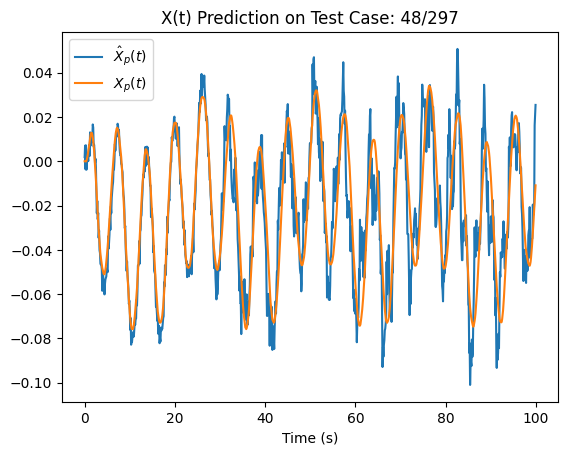

In [ ]:
plt.plot(time,estimated_xp[test_run,:],label="$\hat{X}_{p}(t)$")
plt.plot(time, xp_true[test_run,:],label="$X_{p}(t)$")

plt.xlabel('Time (s)')
plt.legend()
plt.title(f'X(t) Prediction on Test Case: {test_run}/{len(Xtest_flattened)}')

In [ ]:
tld_est_int = tld_est[test_run,:]
tlg_est_int = tlg_est[test_run,:]
tau_est_int = tau_est[test_run,:]
tau_est_avg = tau_est_int.mean()
kp_est_int = kp_est[test_run,:]

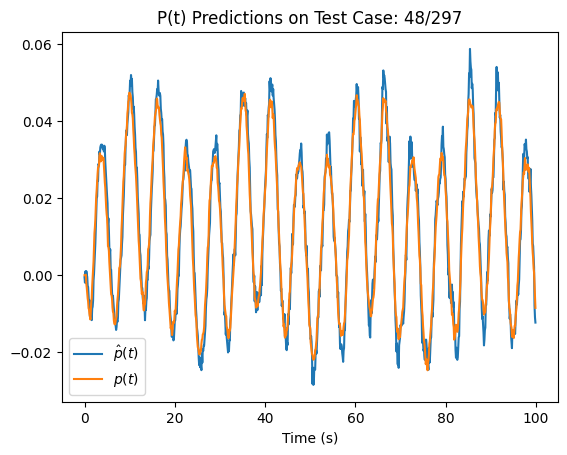

In [ ]:
pitcherror_t_tau = transport_delay(pitcherrortest[test_run,:], tau_est_avg, 0.1, pitcherrortest[test_run,:][0])

pilot_output_predicted = (-kp_est_int/(tlg_est_int*tlg_est_int)) * (tlg_est_int-tld_est_int) * estimated_xp[test_run,:] - (kp_est_int*tld_est_int/tlg_est_int)*pitcherror_t_tau

plt.plot(time,pilot_output_predicted,label="$\hat{p}(t)$")
plt.plot(time, ptest[test_run,:], label="$p(t)$")
plt.xlabel('Time (s)')
plt.legend()
plt.title(f'P(t) Predictions on Test Case: {test_run}/{len(Xtest_flattened)}');

In [ ]:
# Initialize an empty list to store the tensors
pilot_output_predicted_list = []

for k in range(len(Xtest_flattened)):
  tld_est_int = tld_est[k,:]
  tlg_est_int = tlg_est[k,:]
  tau_est_int = tau_est[k,:]
  tau_est_avg = tau_est_int.mean()
  kp_est_int = kp_est[k,:]

  pitcherror_t_tau = transport_delay(pitcherrortest[k,:], tau_est_avg, 0.1, pitcherrortest[k,:][0])
  pilot_output_predicted = (-kp_est_int/(tlg_est_int*tlg_est_int)) * (tlg_est_int-tld_est_int) * estimated_xp[k,:] - (kp_est_int*tld_est_int/tlg_est_int)*pitcherror_t_tau

  # Append to the list
  pilot_output_predicted_list.append(pilot_output_predicted)


# Convert the list to a 2D tensor (NumPy array)
pilot_output_predicted_tensor = np.stack(pilot_output_predicted_list)

pilot_output_predicted_tensor.shape, ptest.shape

((148, 1000), torch.Size([148, 1000]))

In [ ]:
mean_squared_error(ptest,pilot_output_predicted_tensor)

4.0096325e-05

# save the model

In [ ]:
#torch.save(model_1.state_dict(), 'model_state_dict_3.pth') #uncomment to save the model